In [77]:
%config StoreMagics.autorestore = True
%reset -f
# %store -z
%store -r
%whos

Variable                     Type              Data/Info
--------------------------------------------------------
PDMultiParamsMOR_results     list              n=2500
Tsam                         float             0.75
fullOrder                    int               80
hatMathcalPcl                LinearIOSystem    <LinearIOSystem>: sys[122<...> 0.000e+00  0.000e+00]]\n
hatMathcalPext               LinearIOSystem    <LinearIOSystem>: sys[86]<...> [0. 0.]\n     [0. 0.]]\n
hsvMathcalPext               ndarray           80: 80 elems, type `float64`, 640 bytes
mathcalC                     StateSpace        A = [[-100.]]\n\nB = [[1.<...>[[-8.]]\n\nD = [[0.08]]\n
mathcalEext                  LinearICSystem    <LinearICSystem>: sys[93]<...> [0. 0.]\n     [0. 0.]]\n
mathcalP                     LinearIOSystem    <LinearIOSystem>: sys[34]<...>[[0. 0.]\n     [0. 0.]]\n
mathcalPcl                   LinearIOSystem    <LinearIOSystem>: sys[117<...>[[0. 0.]\n     [0. 0.]]\n
mathcalPext              

In [78]:
import pickle
import numpy
import sympy
import scipy
import control
import time
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import cm
from matplotlib.ticker import MaxNLocator

import multiprocessing
from joblib import Parallel, delayed  
from tqdm.notebook import tqdm
import psutil

from custom_utils import ControlUtils
from custom_utils import ODEUtils

from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML

from PIL import Image

numpy.set_printoptions(precision=3)
sympy.init_printing(use_latex='mathjax', use_unicode=True)
sympy.init_printing()
plt.rcParams.update({ "text.usetex": True, "font.family": "Helvetica", "axes.titley": 1.0 } )
%matplotlib inline

In [79]:
s = control.TransferFunction.s
def PDMultiParamsMOR_func(Kp, Td, N, Tsam):
        # Create controller with given parameters
        # num =  [ (Kp/Td) * N * (N + Td), (Kp/Td) * N * (1.0/Td) ]
        # den = [ 1, N/Td ]
        num =  [ Kp*((Td/N)+Td), Kp ]
        den = [ (Td/N), 1 ]
        mathcalC = control.tf2ss(num,den)
        
        # Norm operator Delta
        normInfDelta = 2*Tsam/numpy.pi

        mathcalCPrime = control.ss(mathcalC.A,mathcalC.B,mathcalC.C,numpy.zeros(mathcalC.D.shape))
        tfMathcalCPrime = control.ss2tf(mathcalCPrime)
        kappa_dv = normInfDelta * ControlUtils.hinfnorm(mathcalC)[0] \
                                + normInfDelta * ControlUtils.hinfnorm(s * tfMathcalCPrime)[0] * normInfDelta \
                                + ControlUtils.hinfnorm(tfMathcalCPrime)[0] * normInfDelta 
        #######################################################################                        
        # Creating closed-loop
        # Controller matrices
        Ac = mathcalC.A
        Bv = mathcalC.B
        Cw = mathcalC.C
        Dw = mathcalC.D
        #######################################################################
        # FOM extended plant
        Ap = mathcalPext.A
        Bw = mathcalPext.B[:,0:1]
        Bu = mathcalPext.B[:,1:2]
        Cv = mathcalPext.C[0:1,:]
        Cy = mathcalPext.C[-1:,:]
        Dv = mathcalPext.D[0:1,:]
        Dy = mathcalPext.D[-1:,:]
        # Closed-loop with FOM Extended Plant
        Acl = numpy.row_stack( [ numpy.column_stack( [ Ap + Bw@Dw@Cv, Bw@Cw ] ),
                                    numpy.column_stack( [ Bv@Cv, Ac ] )
                                    ] )
        Bcl = numpy.row_stack( [ numpy.column_stack([Bw, Bu]),
                                    numpy.column_stack( [ numpy.zeros( (Ac.shape[0],Bw.shape[1]) ), numpy.zeros( (Ac.shape[0],Bu.shape[1]) ) ] )
                                    ] )
        Ccl = numpy.row_stack( [ # numpy.column_stack( [ Cv, numpy.zeros( (Cv.shape[0],Ac.shape[0]) ) ] ),
                                    numpy.column_stack( [ Cv@Ap + Cv@Bw@Dw@Cv, Cv@Bw@Cw ] ),
                                    numpy.column_stack( [ Cy, numpy.zeros( (Cy.shape[0],Ac.shape[0]) ) ] )
                                    ] )
        Dcl = numpy.row_stack( [ # numpy.column_stack( [ numpy.zeros( (Cv.shape[0],Bw.shape[1]) ), numpy.zeros( (Cv.shape[0],Bu.shape[1]) ) ] ),
                                    numpy.column_stack( [ Cv@Bw , Cv@Bu] ),
                                    numpy.column_stack( [ numpy.zeros( (Cy.shape[0],Bw.shape[1]) ), numpy.zeros( (Cy.shape[0],Bu.shape[1]) ) ] )
                                    ] )
        mathcalPcl = control.ss(Acl,Bcl,Ccl,Dcl)
        normInfMathcalPcl, normInfMathcalPcl_MIMO = ControlUtils.hinfnorm( mathcalPcl )
        #######################################################################
        # ROM extended plant
        hatAp_ext = hatMathcalPext.A
        hatBw_ext = hatMathcalPext.B[:,0:1]
        hatBu_ext = hatMathcalPext.B[:,1:2]
        hatCv_ext = hatMathcalPext.C[0:1,:]
        hatCy_ext = hatMathcalPext.C[-1:,:]
        hatDv_ext = hatMathcalPext.D[0:1,:]
        hatDy_ext = hatMathcalPext.D[-1:,:]
        # Closed-loop with ROM Extended Plant
        hatAcl = numpy.row_stack( [ numpy.column_stack( [ hatAp_ext + hatBw_ext@Dw@hatCv_ext, hatBw_ext@Cw ] ),
                                    numpy.column_stack( [ Bv@hatCv_ext, Ac ] )
                                    ] )
        hatBcl = numpy.row_stack( [ numpy.column_stack([hatBw_ext, hatBu_ext]),
                                    numpy.column_stack( [ numpy.zeros( (Ac.shape[0],hatBw_ext.shape[1]) ), numpy.zeros( (Ac.shape[0],hatBu_ext.shape[1]) ) ] )
                                    ] )
        hatCcl = numpy.row_stack( [ # numpy.column_stack( [ hatCv_ext, numpy.zeros( (hatCv_ext.shape[0],Ac.shape[0]) ) ] ),
                                    numpy.column_stack( [ hatCv_ext@hatAp_ext + hatCv_ext@hatBw_ext@Dw@hatCv_ext, hatCv_ext@hatBw_ext@Cw ] ),
                                    numpy.column_stack( [ hatCy_ext, numpy.zeros( (hatCy_ext.shape[0],Ac.shape[0]) ) ] )
                                    ] )
        hatDcl = numpy.row_stack( [ # numpy.column_stack( [ numpy.zeros( (hatCv_ext.shape[0],hatBw_ext.shape[1]) ), numpy.zeros( (hatCv_ext.shape[0],hatBu_ext.shape[1]) ) ] ),
                                    numpy.column_stack( [ hatCv_ext@hatBw_ext , hatCv_ext@hatBu_ext] ),
                                    numpy.column_stack( [ numpy.zeros( (hatCy_ext.shape[0],hatBw_ext.shape[1]) ), numpy.zeros( (hatCy_ext.shape[0],hatBu_ext.shape[1]) ) ] )
                                    ] )
        hatMathcalPcl = control.ss(hatAcl,hatBcl,hatCcl,hatDcl)
        normInfHatMathcalPcl, normInfHatMathcalPcl_MIMO = ControlUtils.hinfnorm( hatMathcalPcl )
        #######################################################################
        
        # Computing norms for small-gain stability condition 
        mathcalEcl = mathcalPcl - hatMathcalPcl
        normInfMathcalEcl, normInfMathcalEcl_MIMO = ControlUtils.hinfnorm( mathcalEcl )
        
        return (mathcalPext, hatMathcalPext, mathcalC, Kp, Td, N, Tsam,
                mathcalPcl, normInfMathcalPcl, normInfMathcalPcl_MIMO,
                hatMathcalPcl, normInfHatMathcalPcl, normInfHatMathcalPcl_MIMO,
                mathcalEcl, normInfMathcalEcl, normInfMathcalEcl_MIMO, 
                kappa_dv)

In [119]:
# Loop parameters
# kp_kd_steps = 5
kp_kd_steps = 200
kps = numpy.linspace(50.0e-6, 100.0e-6, kp_kd_steps)
tds = numpy.linspace(10.0e0, 10.0e0, kp_kd_steps)
N = 1.0e3

samplings_lims = [700.0e-3,1000.0e-3]
# samplings_steps = 5
samplings_steps = 200
samplings = numpy.linspace(samplings_lims[0],samplings_lims[1],samplings_steps)

# Creation of arguements lists for the parallel execution of function smallgain_condition(*args)
jobs_args_list = []
for i in range(samplings_steps):
    for j in range(kp_kd_steps):
        jobs_args_list.append([(i,j),(kps[j], tds[j], N, samplings[i])])

Jobs execution

In [120]:
# Execution of jobs using multiprocess managed by Parallel 
# (Very recommended since standard python multithread does not take advantage of all cores due to GIL)
# (The other option is to use CPython)
num_cores = multiprocessing.cpu_count()
PDMultiParamsMOR_results = Parallel(n_jobs=num_cores)\
                        (\
                            delayed( lambda idx,args: (idx, PDMultiParamsMOR_func(*args)) )\
                                ( jobs_args_list[k][0], jobs_args_list[k][1] )\
                                for k in tqdm(range(len(jobs_args_list)), position=0)\
                        )

# Save the computation results to a pickle with timestamp
utcnow, micros = datetime.now().strftime('%Y_%m_%d-%H_%M_%S.%f').split('.') 
pickle_filename = "PDMultiParamsMOR_results_{0}_{1}.pickle".format( utcnow, micros[:-3] ) 
with open(pickle_filename, 'wb') as f:
    pickle.dump(PDMultiParamsMOR_results, f) 

  0%|          | 0/40000 [00:00<?, ?it/s]

Load previous results

In [82]:
# Read the computation results from a pickle with timestamp
# pickle_filename = "PDMultiParamsMOR_results_2023_11_16-05_02_17_595.pickle"
with open(pickle_filename, 'rb') as f:
    PDMultiParamsMOR_results = pickle.load(f)

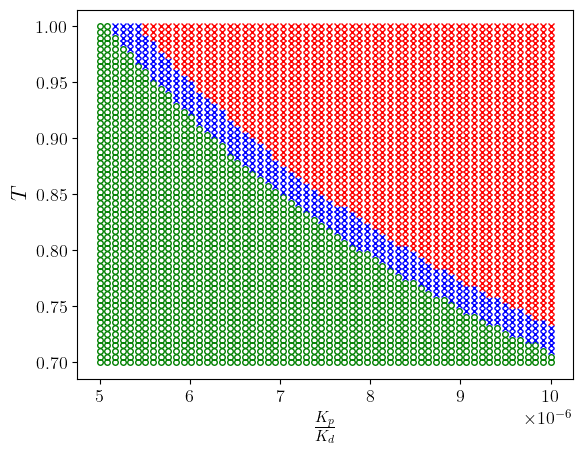

In [83]:
for k in range(len(PDMultiParamsMOR_results)): 
    (i,j),(mathcalPext, hatMathcalPext, mathcalC, Kp, Td, N, Tsam, 
                mathcalPcl, normInfMathcalPcl, normInfMathcalPcl_MIMO, 
                hatMathcalPcl, normInfHatMathcalPcl, normInfHatMathcalPcl_MIMO, 
                mathcalEcl, normInfMathcalEcl, normInfMathcalEcl_MIMO, 
                kappa_dv) = PDMultiParamsMOR_results[k] 
    
    # A priori stability condition
    small_gain_cond_FOM = normInfMathcalPcl*kappa_dv
    small_gain_cond_ROM = (normInfMathcalPcl+normInfMathcalEcl)*kappa_dv
    
    # Gains ratio for plot
    kp_td = Kp/Td
    
    if(small_gain_cond_FOM>=1):
        plt.plot(kp_td, Tsam, marker="x", markersize=4, markerfacecolor='r', markeredgecolor='r')
    elif(small_gain_cond_ROM>=1):
        plt.plot(kp_td, Tsam, marker="x", markersize=4, markerfacecolor='b', markeredgecolor='b')
    else:
        plt.plot(kp_td, Tsam, marker="o", markersize=4, markerfacecolor='none', markeredgecolor='g')

plt.ticklabel_format(axis='y', scilimits=(-0,-0))
plt.ticklabel_format(axis='x', scilimits=(-6,-6))
plt.tick_params(axis='y', labelsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.gca().yaxis.get_offset_text().set_fontsize(13)
plt.gca().xaxis.get_offset_text().set_fontsize(13)
plt.ylabel('$T$', fontsize=16)
plt.xlabel('$\\frac{K_p}{K_d}$', fontsize=16)
plt.savefig('smallgain_cond_pd_kp_kd_ratio.png', format='png')
plt.show()

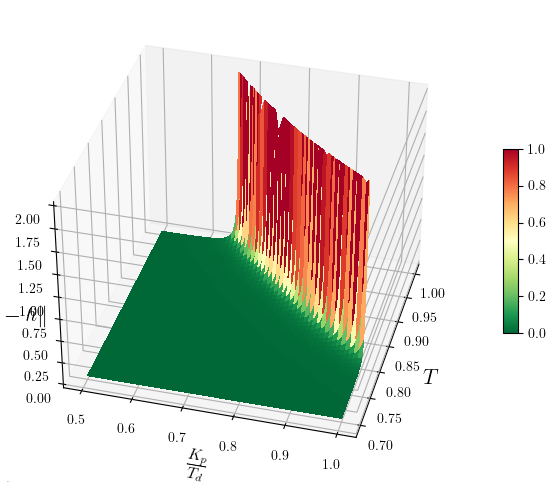

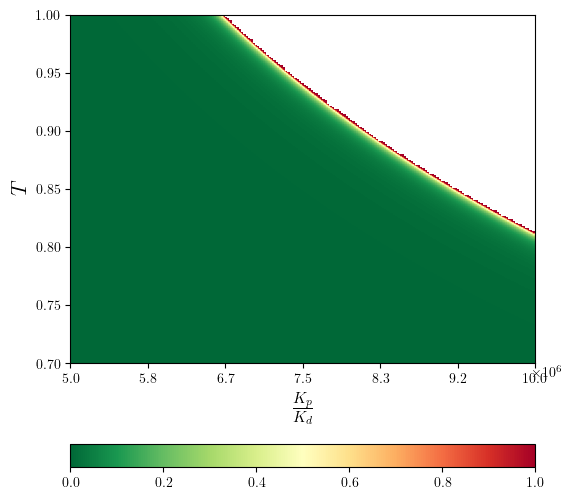

In [157]:
imax = max(PDMultiParamsMOR_results, key=lambda x: x[0][0])[0][0] + 1
jmax = max(PDMultiParamsMOR_results, key=lambda x: x[0][1])[0][1] + 1

samp_Y = numpy.empty((imax,jmax))
samp_Y.fill(numpy.nan)
kp_td_X = numpy.empty((imax,jmax))
kp_td_X.fill(numpy.nan)
eps_u_y_cl_Z = numpy.empty((imax,jmax))
eps_u_y_cl_Z.fill(numpy.nan)

for k in range(len(PDMultiParamsMOR_results)):
    (i,j),(mathcalPext, hatMathcalPext, mathcalC, Kp, Td, N, Tsam,
                mathcalPcl, normInfMathcalPcl, normInfMathcalPcl_MIMO,
                hatMathcalPcl, normInfHatMathcalPcl, normInfHatMathcalPcl_MIMO,
                mathcalEcl, normInfMathcalEcl, normInfMathcalEcl_MIMO, 
                kappa_dv) = PDMultiParamsMOR_results[k]
        
    gamma_w_dv = normInfMathcalPcl_MIMO[0,0]
    gamma_w_y  = normInfMathcalPcl_MIMO[1,0]
    gamma_u_dv = normInfMathcalPcl_MIMO[0,1]
    gamma_u_y  = normInfMathcalPcl_MIMO[1,1]
    hat_gamma_w_dv = normInfHatMathcalPcl_MIMO[0,0]
    hat_gamma_w_y  = normInfHatMathcalPcl_MIMO[1,0]
    hat_gamma_u_dv = normInfHatMathcalPcl_MIMO[0,1]
    hat_gamma_u_y  = normInfHatMathcalPcl_MIMO[1,1]
    eps_w_dv = normInfMathcalEcl_MIMO[0,0]
    eps_w_y  = normInfMathcalEcl_MIMO[1,0]
    eps_u_dv = normInfMathcalEcl_MIMO[0,1]
    eps_u_y  = normInfMathcalEcl_MIMO[1,1]
    
    # The values for which the denominators are negative are not valid, then they are transformed to nan
    den_hat_gamma = (1-kappa_dv*hat_gamma_w_dv)
    den_gamma = (1-kappa_dv*gamma_w_dv)
    if den_hat_gamma<=0 or den_gamma<=0: eps_u_y_cl = numpy.nan
    else: eps_u_y_cl = ( hat_gamma_w_y/den_hat_gamma )*( (kappa_dv**2)*gamma_u_dv*eps_w_dv/den_gamma + kappa_dv*eps_u_dv ) \
            + kappa_dv*gamma_u_dv*eps_w_y/den_gamma \
            + eps_u_y
    # print(eps_u_y_cl, "\t", Kp/Td, "\t", Tsam, "\t", (1-kappa_dv*hat_gamma_w_dv), "\t", (1-kappa_dv*gamma_w_dv))
    if eps_u_y_cl is not numpy.nan and eps_u_y_cl > 2.0: eps_u_y_cl=2.0
        
    samp_Y[i,j] = Tsam
    kp_td_X[i,j] = Kp/Td
    eps_u_y_cl_Z[i,j] = eps_u_y_cl
    # eps_u_y_cl_Z[i,j] = numpy.log10(1+20*eps_u_y_cl)

plt.subplots(figsize=(8,6), subplot_kw={"projection": "3d"})
surf = plt.gca().plot_surface(kp_td_X, samp_Y, eps_u_y_cl_Z, cmap=mpl.colormaps['RdYlGn_r'], linewidth=0, antialiased=False, vmin=-0, vmax=1.0)
plt.gca().view_init(elev=35, azim=-75)
plt.xlabel('$\\frac{K_p}{T_d}$', fontsize=16)
plt.ylabel('$T$', fontsize=16)
plt.gca().zaxis.set_rotate_label(False)
tmp_planes = plt.gca().zaxis._PLANES 
plt.gca().zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                            tmp_planes[0], tmp_planes[1], 
                            tmp_planes[4], tmp_planes[5])
plt.gca().set_zlabel('$\\| y - \\hat{y} \\|_{\\mathcal{L}_{2}} $', fontsize=16, rotation=180)
plt.gca().set_zlim(-0, 2.0)
plt.gcf().colorbar(surf, shrink=0.4, aspect=12)
plt.show()

# eps_u_y_cl_Z = list(map(list, zip(*eps_u_y_cl_Z[::-1])))[::-1]
eps_u_y_cl_Z = eps_u_y_cl_Z[::-1,:]
# eps_u_y_cl_Z = eps_u_y_cl_Z[:,::-1]
plt.subplots(figsize=(6,7))
plt.imshow(eps_u_y_cl_Z, cmap=mpl.colormaps['RdYlGn_r'], vmin=-0, vmax=1.0, extent=[0, jmax, 0, imax], aspect=6.0/8.0)
plt.gca().set_xticks(numpy.linspace(0,jmax,7))
plt.gca().set_xticklabels(["${0:.1f}$".format(tick*10e5) for tick in numpy.linspace(min(kp_td_X[0,:]),max(kp_td_X[0,:]),7)])
plt.text(jmax-1, -7, "$\\times 10^{6}$", fontsize=10)
plt.gca().set_yticks(numpy.linspace(0,imax,7))
plt.gca().set_yticklabels(["${0:.2f}$".format(tick) for tick in numpy.linspace(min(samp_Y[:,0]),max(samp_Y[:,0]),7)])
plt.colorbar(orientation="horizontal", pad=0.15)
plt.xlabel('$\\frac{K_p}{K_d}$', fontsize=16)
plt.ylabel('$T$', fontsize=16)
plt.savefig('performance_error_bound.png', format='png')
plt.show()



In [85]:
%store -d PDMultiParamsMOR_results
%store PDMultiParamsMOR_results

Stored 'PDMultiParamsMOR_results' (list)
